In [1]:
!pip install wordcloud -q

# Анализ QA датасета HotPot

In [114]:
import spacy
import json
import random
import nltk
import pandas as pd
import numpy as np
import seaborn as sns

from collections import Counter
from nltk import ngrams
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
from string import punctuation
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize

pd.set_option('max_colwidth', None)
nltk.download('punkt')
tqdm.pandas()
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
datapath = '/content/drive/MyDrive/AI HW/year_project/hotpot_data_info.tsv'
train_path = '/content/drive/MyDrive/AI HW/year_project/hotpot_train_v1.1.json'
dev_distractor_path = '/content/drive/MyDrive/AI HW/year_project/hotpot_dev_distractor_v1.json'
dev_wiki_path = '/content/drive/MyDrive/AI HW/year_project/hotpot_dev_fullwiki_v1.json'

## 1. Скачивание данных

In [2]:
# # Download GloVe
# !GLOVE_DIR=./
# !mkdir -p $GLOVE_DIR
# !wget http://nlp.stanford.edu/data/glove.840B.300d.zip -O $GLOVE_DIR/glove.840B.300d.zip
# !unzip $GLOVE_DIR/glove.840B.300d.zip -d $GLOVE_DIR

# # Download Spacy language models
# !python3 -m spacy download en

## 2. Описание датасета

HotPot датасет - это набор данных для задачи поиска ответа на вопрос с множествеными вариантами ответа. Данный датасет предполагает помимо выдачи правильного ответа также выдачу фактов из текста, которые подтверждают ответ. Для этого контекст разделен на предложения. Задача выглядит следующим образом: модель получает на вход контекст и вопрос и должна вывести правильный ответ и id предложений, пдтверждающих ответ.

Валидационных датасета два: distractor и wiki. В первом вариаенте в качестве контекста даются проверенные параграфы текста, а во втором топ-10 подходящих под вопрос статей с википедии. Эти статьи предложены авторами, но участникам предлагается также попробовать подобрать свои статьи.

Все вопросы делятся на 2 категории: bridge и comparison. Вопросы первого типа предполагают, что для ответа модель должна найти "промежуточный" ответ, на основе которого можно будет вычислить итоговый. Например, для ответа на вопрос: "В каком году день рождения у главного исполнителя группы The Beatles?" - нужно сначала определить, кто является главным исполнителем ("промежуточный" ответ), а после вычислить год рождения.

Вопросы второго типа построены на сравнении двух сущностей из одной категории, например, "Кто играл в большем количестве команд NBA, Майкл Джордан или Коби Брайант?". Среди таких вопросов так же можно найти "да/нет" вопросы, например, "Из одной ли страны группы Iron Maiden и AC/DC".

Все вопросы в обучающем датасете делятся на категории: easy, medium и hard. В валидационном и тестовом датасетах вопросы только категории hard. Вопросы категории easy в основном относятся к категории "single-hop questions", то есть вопросы, для ответа на которые достаточно проверить один ресурс.



In [5]:
with open(train_path) as f:
    train = json.loads(f.read())

with open(dev_distractor_path) as f:
    dev_distractor = json.loads(f.read())

with open(dev_wiki_path) as f:
    dev_wiki = json.loads(f.read())

In [6]:
print('Количество примеров в обучающем датасете', len(train))
print('Количество примеров в валидационном датасете, дистрактор', len(dev_distractor))
print('Количество примеров в валидационном датасете, википедия', len(dev_wiki))

Количество примеров в обучающем датасете 90447
Количество примеров в валидационном датасете, дистрактор 7405
Количество примеров в валидационном датасете, википедия 7405


Пример вопрос-ответа:

In [6]:
random.choice(train)

{'supporting_facts': [['Jo In-sung', 2], ['The King (2017 film)', 0]],
 'level': 'hard',
 'question': 'Jo In-sung stars in the 2017 political crime thriller released in what country?',
 'context': [['Spring Day (TV series)',
   ['Spring Day () is a 2005 South Korean television drama series starring Go Hyun-jung, Jo In-sung, and Ji Jin-hee.',
    ' Loosely adapted from the 1995 Japanese drama "Heaven\'s Coins" (星の金貨 , Hoshi no Kinka ) , it aired on SBS from January 8 to March 13, 2005 on Saturdays and Sundays at 21:45 for 20 episodes.']],
  ["It's Okay, That's Love",
   ["It's Okay, That's Love () is a 2014 South Korean television series starring Jo In-sung, Gong Hyo-jin, Sung Dong-il, Lee Kwang-soo and Do Kyung-soo.",
    ' It aired on SBS from July 23 to September 11, 2014 on Wednesdays and Thursdays at 21:55 for 16 episodes.']],
  ['Jo In-sung',
   ['Jo In-sung (; born July 28, 1981) is a South Korean actor.',
    ' He is 189 cm tall.',
    ' He is best known for his leading roles in

##  3. Сбор данных

__Столбцы:__
- question: вопрос
- answer: ответ на вопрос
- level: уровень сложности вопроса
- type: типа вопроса
- num_of_ctx: количество параграфов контекста
- num_of_words: количество слов во всех параграфах вопроса

In [27]:
all_data = pd.DataFrame(columns=['question', 'answer', 'level', 'type', 'num_of_ctx', 'num_of_words'])

all_words = []
for data in tqdm(train):
    num_of_words = 0
    sents_num = 0

    all_contexts = data['context']
    for context in all_contexts:
        sents = ' '.join([context[0]] + context[1])
        sents_num += len([context[0]] + context[1])
        words = word_tokenize(sents)
        num_of_words += len(words)
        all_words.append(words)

    question = {
        'question': [data['question']],
        'level': [data['level']],
        'answer': [data['answer']],
        'type': [data['type']],
        'num_of_ctx': [len(all_contexts)],
        'num_of_sents': [sents_num],
        'num_of_words': [num_of_words],
    }
    one_data = pd.DataFrame(question)
    all_data = pd.concat([all_data, one_data])

100%|██████████| 90447/90447 [41:25<00:00, 36.39it/s]


In [36]:
all_data.reset_index(drop=True).to_csv(datapath, sep='\t')

### 4. Аналитика

#### Анализ метаданных
__Числовые данные__

In [116]:
all_data = pd.read_csv(datapath, sep='\t', index_col=0)
all_data['answer_length'] = all_data.answer.progress_apply(lambda txt: len(word_tokenize(txt)))
all_data['question_length'] = all_data.question.progress_apply(lambda txt: len(word_tokenize(txt)))

100%|██████████| 90447/90447 [00:17<00:00, 5064.14it/s]


In [117]:
all_data.describe()

,num_of_ctx,num_of_words,num_of_sents,answer_length,question_length
count,90447.000000,90447.000000,90447.000000,90447.000000,90447.000000
mean,9.946897,1080.412606,50.891804,2.380742,19.984754
std,0.590802,293.773559,11.363687,2.194618,11.007101
min,2.000000,35.000000,4.000000,1.000000,4.000000
25%,10.000000,889.000000,44.000000,1.000000,13.000000
50%,10.000000,1059.000000,50.000000,2.000000,17.000000
75%,10.000000,1248.000000,57.000000,3.000000,23.000000
max,10.000000,3152.000000,154.000000,145.000000,128.000000


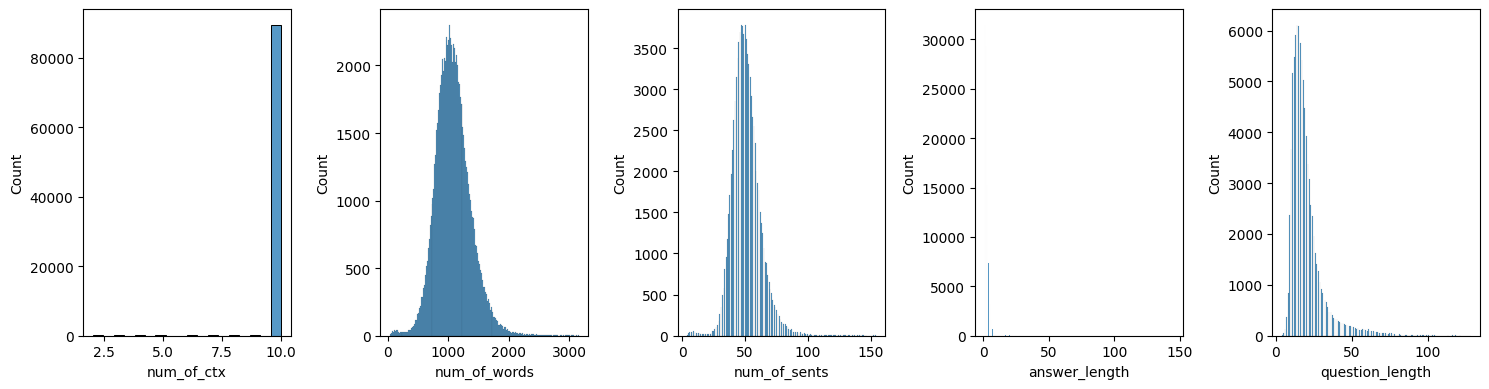

In [210]:
fig, axes = plt.subplots(1, 5, figsize=(15, 4))
sns.histplot(all_data, x='num_of_ctx', ax=axes[0])
sns.histplot(all_data, x='num_of_words', ax=axes[1])
sns.histplot(all_data, x='num_of_sents', ax=axes[2])
sns.histplot(all_data, x='answer_length', ax=axes[3])
sns.histplot(all_data, x='question_length', ax=axes[4])
plt.tight_layout()
plt.savefig('distribution_of_numbers.png')
plt.show()

In [124]:
all_data.loc[(all_data.num_of_ctx<10)].describe()

,num_of_ctx,num_of_words,num_of_sents,answer_length,question_length
count,838.000000,838.000000,838.000000,838.000000,838.000000
mean,4.268496,347.155131,18.719570,1.747017,9.476134
std,2.265683,254.897608,12.089427,2.231085,1.882137
min,2.000000,35.000000,4.000000,1.000000,4.000000
25%,2.000000,144.000000,9.000000,1.000000,8.000000
50%,4.000000,273.500000,15.000000,1.000000,9.000000
75%,6.000000,488.500000,26.000000,2.000000,10.000000
max,9.000000,1441.000000,69.000000,37.000000,20.000000


__Тектовые данные__

Есть повторяющиеся вопросы (7 вопросов). Среди них есть те, в которых есть полные повторения, и те, где отличается уровень вопроса. Так как уровень вопроса не требуется в обучении модели, можно оставить любой из повторяющихся вопросов.

In [10]:
all_data.describe(include='object')

,question,answer,level,type
count,90447,90447,90447,90447
unique,90440,53237,3,2
top,"Sangerville Town Hall is located at 1 Town Hall Lane (corner of South Main Street) in the village center of Sangerville, Maine, Sangerville is a town in Piscataquis County, Maine, in which country?",yes,medium,bridge
freq,2,2748,56814,72991


In [207]:
all_data = all_data[~all_data.duplicated(subset='question')]

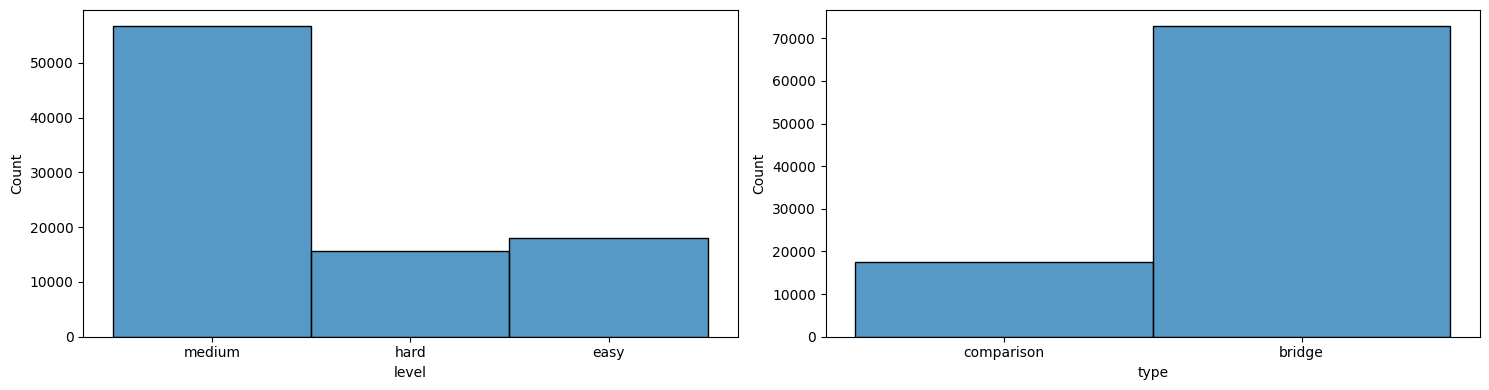

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(all_data, x='level', ax=axes[0])
sns.histplot(all_data, x='type', ax=axes[1])
plt.tight_layout()
plt.savefig('distribution_of_level_type.png')
plt.show()

In [111]:
all_data.groupby(['level', 'type'])['answer'].agg('count')t

level   type      
easy    bridge        14466
        comparison     3506
hard    bridge        12451
        comparison     3210
medium  bridge        46074
        comparison    10740
Name: answer, dtype: int64

__Выводы:__
- В среднем контекст состоит из 1080 слов, максимальное количество токенов ~3152.
- Почти все вопросы имеют 10 параграфов контекста, только 838 вопросов имеют меньше
- Больше всего вопросов имеют средний уровень сложности
- Тип вопроса "bridge" наиболее часто встречается в данных
- Среди ответов можно выделить наиболее частый, так как есть вопросы типа "yes/no", соответсвенно самые частые ответы также "yes/no"

#### Анализ ответов

Среди частых ответов помимо "да" и "нет" можно встретиться так же названися стран, годы, профессии, животных - названия, которые неуникальны и часто могут являться ответами.

In [11]:
all_data.answer.value_counts()[:10]

,count
answer,
yes,2748
no,2733
American,617
United States,290
film director,208
English,169
magazine,159
New York City,157
film,152


В статье авторов датасета также указано распределение ответов по типам:

![answers_types.png](https://drive.google.com/uc?export=view&id=124wueWxHQEbkoTRiGLg813Db4MI4If2l)


__Н-граммы__

Униграммы

In [215]:
all_answer_words = ' '.join(all_data['answer']).lower().split()

In [216]:
all_answer_words_1 = Counter(ngrams(all_answer_words, 1))
all_answer_words_2 = Counter(ngrams(all_answer_words, 2))
all_answer_words_3 = Counter(ngrams(all_answer_words, 3))

In [220]:
for word1, word2, word3 in zip(
    all_answer_words_1.most_common(10),
    all_answer_words_2.most_common(10),
    all_answer_words_3.most_common(10)
    ):

    print(
        ' '.join(word1[0]) + ' ' + str(word1[1]),
        ' '.join(word2[0]) + ' ' + str(word2[1]),
        ' '.join(word3[0]) + ' ' + str(word3[1]),
        sep='\t|\t'
    )

the 5734	|	of the 590	|	new york city 190
of 3433	|	united states 535	|	world war ii 93
no 2766	|	new york 461	|	the university of 66
yes 2749	|	university of 420	|	the united states 60
and 2479	|	film director 246	|	professional tennis player 46
american 1048	|	and the 213	|	people's republic of 44
university 951	|	in the 209	|	republic of china 44
new 882	|	york city 190	|	big 12 conference 40
a 845	|	battle of 171	|	the battle of 39
in 806	|	world war 142	|	saturday night live 30


__Статистика по символам__

In [218]:
all_answer_chars = list(''.join(all_data['answer']).lower())
all_answer_chars_1 = Counter(ngrams(all_answer_chars, 1))
all_answer_chars_2 = Counter(ngrams(all_answer_chars, 2))
all_answer_chars_3 = Counter(ngrams(all_answer_chars, 3))

In [219]:
for char1, char2, char3 in zip(
    all_answer_chars_1.most_common(10),
    all_answer_chars_2.most_common(10),
    all_answer_chars_3.most_common(10)
    ):
    print(
        ''.join(char1[0]) + ' ' + str(char1[1]),
        ''.join(char2[0]) + ' ' + str(char2[1]),
        ''.join(char3[0]) + ' ' + str(char3[1]),
        sep=' | '
    )

  110906 | an 22741 | the 7294
e 110687 | er 20999 | he  6102
a 103974 | e  16731 | and 5912
n 83856 | ar 14215 | er  4220
r 79761 | on 14105 | ing 3544
i 76883 | in 13869 | an  3521
o 73599 | th 11922 |  of 3517
t 65986 | es 11865 | of  3446
s 63724 | n  11563 | ion 3364
l 54040 | en 11270 | nd  3345


__Статистика по частям речи__

In [177]:
answer_pos = all_data.answer.progress_apply(lambda txt: [token.pos_ for token in nlp(txt)])

100%|██████████| 90447/90447 [11:13<00:00, 134.24it/s]


In [180]:
answer_pos.explode().value_counts()

,count
answer,
PROPN,122020
NOUN,24265
NUM,19673
PUNCT,14179
ADJ,7320
DET,7157
ADP,6758
INTJ,5634
VERB,4182


#### Анализ вопросов

Хочется понять, а на какие вопросы в основном требуется ответ. Для этого можно посмотреть на вопросительные слова, которые так же называются wh-словами. Кроме них вопрос может создаваться словами "is", "are", "did" и подобными.Посмотрим на их количество. Для лучшей визуализации, построим облако слов.

Обычно вопросительные слова находятся в начале, но может быть так, что сначала идет некоторая "описательная" часть, после которой уже формируется вопрос. Если вопросительное слово не было найдено в начале, то для того, чтобы избежать ситуации, когда wh-слово употребляется в относительных предложениях ("I don't know where he is"), будем смотреть на слова с конца и искать первое слово, которое относится к нашему списку wh_words. (То есть считаем, что вопрос формируется либо в самом начале, либо в самом конце вопроса)

In [42]:
preps = ['in', 'at', 'on', 'under', 'upon', 'before', 'after', 'with', 'of']
wh_words = [
    'what', 'who', 'whom', 'whose',
    'where', 'which', 'when', 'where',
    'why', 'how', 'is', 'are', 'was', 'were'
]

In [57]:
def get_qw(question):
    words = question.split()
    first_word = words[0].lower()
    if first_word in preps:
        question_word = first_word + ' ' + words[1].lower()
        return question_word
    if first_word not in wh_words:
        for i in range(len(words)-1, 0, -1):
            if (words[i] in wh_words) and (words[i-1] in preps):
                return words[i-1] + ' ' + words[i]
            elif words[i] in wh_words:
                return words[i]
    return first_word

In [58]:
all_data['question_word'] = all_data.question.apply(get_qw)

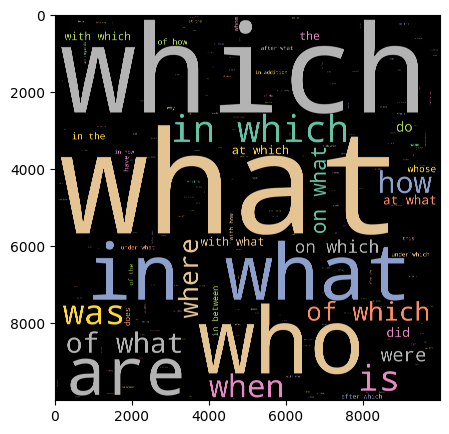

In [60]:
wordCloud = WordCloud(width = 10000, height = 10000, random_state=1, background_color='black', colormap='Set2', collocations=False)
wordCloud = wordCloud.generate_from_frequencies(dict(all_data.question_word.value_counts()))

plt.figure(figsize=(5,5))
plt.imshow(wordCloud)

In [63]:
wordCloud.to_file('/content/drive/MyDrive/AI HW/year_project/images/question_words_cloud.png')

In [64]:
all_data.question_word.value_counts()[:15]

,count
question_word,
what,24832
which,17729
who,9010
in what,6205
are,4423
in which,3559
is,3256
was,3071
when,2473


Можно так же оценить не только само вопросительное слово, но о чем вопрос в целом, если посмотреть на слово следующее за вопросительным.

In [192]:
def get_qw_full(question):
    words = question.split()
    first_word = words[0].lower()
    if first_word in preps:
        question_word = first_word + ' ' + words[1].lower() + ' ' + words[2].lower().strip(punctuation)
        return question_word
    if first_word not in wh_words:
        for i in range(len(words)-1, 0, -1):
            if (words[i] in wh_words) and (words[i-1] in preps) and (i < (len(words)-1)):
                return words[i-1] + ' ' + words[i] + ' ' + words[i+1].lower().strip(punctuation)
            elif (words[i] in wh_words) and (i < (len(words)-2)):
                return words[i] + ' ' + words[i+1].lower().strip(punctuation) + ' ' + words[i+2].lower().strip(punctuation)
    return first_word + ' ' + words[1].lower().strip(punctuation) + ' ' + words[2].lower().strip(punctuation)

In [193]:
all_data['next_question_word'] = all_data.question.apply(get_qw_full)

In [194]:
all_data.next_question_word.value_counts()[:15]

,count
next_question_word,
what is the,4382
in what year,2993
when was the,1619
what was the,1606
who was the,904
in which year,898
who is the,874
what type of,756
who was born,622


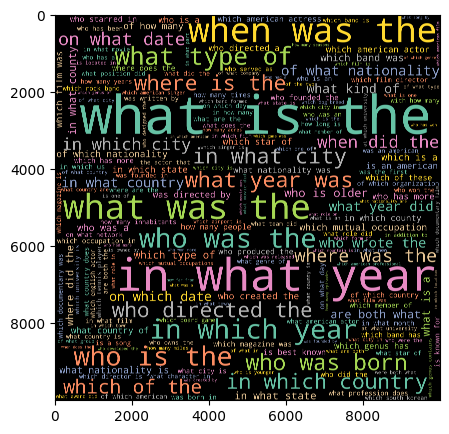

In [195]:
wordCloud = WordCloud(width = 10000, height = 10000, random_state=1, background_color='black', colormap='Set2', collocations=False)
wordCloud = wordCloud.generate_from_frequencies(dict(all_data.next_question_word.value_counts()))

plt.figure(figsize=(5,5))
plt.imshow(wordCloud)

In [221]:
wordCloud.to_file('/content/drive/MyDrive/AI HW/year_project/images/question_trigrams_cloud.png')

__Н-граммы__

Униграммы

In [222]:
all_question_words = ' '.join(all_data['question']).lower().split()
all_question_words_1 = Counter(ngrams(all_question_words, 1))
all_question_words_2 = Counter(ngrams(all_question_words, 2))
all_question_words_3 = Counter(ngrams(all_question_words, 3))

In [223]:
for word1, word2, word3 in zip(
    all_question_words_1.most_common(10),
    all_question_words_2.most_common(10),
    all_question_words_3.most_common(10)
    ):

    print(
        ' '.join(word1[0]) + ' ' + str(word1[1]),
        ' '.join(word2[0]) + ' ' + str(word2[1]),
        ' '.join(word3[0]) + ' .' + str(word3[1]),
        sep='\t|\t'
    )

the 107913	|	of the 19047	|	what is the 4471
of 55818	|	in the 11268	|	name of the 1935
in 50219	|	is the 10072	|	the name of 1923
and 38797	|	was the 9029	|	in what year? 1876
what 36936	|	is a 7545	|	what was the 1750
a 36545	|	in what 6491	|	when was the 1632
is 33601	|	in which 5228	|	is the name 1528
which 32247	|	what is 5127	|	what year was 1367
was 32171	|	who was 4071	|	year was the 1246
who 19497	|	was a 3147	|	have in common? 1243


__Статистика по символам__

In [173]:
all_question_chars = list(''.join(all_data['question']).lower())
all_question_chars_1 = Counter(ngrams(all_question_chars, 1))
all_question_chars_2 = Counter(ngrams(all_question_chars, 2))
all_question_chars_3 = Counter(ngrams(all_question_chars, 3))

In [174]:
for char1, char2, char3 in zip(
    all_question_chars_1.most_common(10),
    all_question_chars_2.most_common(10),
    all_question_chars_3.most_common(10)
    ):
    print(
        ''.join(char1[0]) + ' ' + str(char1[1]),
        ''.join(char2[0]) + ' ' + str(char2[1]),
        ''.join(char3[0]) + ' ' + str(char3[1]),
        sep=' || '
    )

  1530558 || e  230821 ||  th 125232
e 811732 ||  a 179865 || the 120215
a 754263 || n  172955 || he  112030
t 608478 || th 172693 || ed  73627
i 580894 || s  171197 ||  wh 61607
o 559812 ||  t 170222 ||  in 60743
n 548882 || d  149445 || at  58245
r 531204 || he 147518 ||  of 57970
s 469909 || an 144264 || in  56792
h 438005 || er 132899 || of  55915


__Статистика по частям речи__

In [181]:
question_pos = all_data.question.progress_apply(lambda txt: [token.pos_ for token in nlp(txt)])

100%|██████████| 90447/90447 [15:43<00:00, 95.84it/s]


In [182]:
question_pos.explode().value_counts()

,count
question,
PROPN,362118
NOUN,310660
ADP,204010
PUNCT,201171
DET,194652
VERB,143219
ADJ,97160
PRON,96062
AUX,90286


## Предобработка текста

Для решения задачи QA не требуется предобработка данных, так как для ответа на вопрос важно полностью понимать контекст, даже форма слова может нести значение (взять хотя бы _does_ и _did_, несущие в себе информацию о времени действия события). В стоп-слова входят вопросительные слова (wh-слова, о которых я писала выше), которые для задачи ответа на вопрос имеют чуть ли не ключевую роль.

Соотвественно для решения этой задачи предобработка текста, это подготовка к формату входа модели: соответствующая токенизация, деление на параграфы (если это BERT и подобные модели с сильно ограниченным входом) или наоборот склеивание (если это LLM с большим контекстом).